# Block Cipher and RSA

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import math

from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad

## Block Cipher and AES

### Block Ciphers 

A block cipher is a cryptographic algorithm that processes fixed-size blocks of data, typically 64 or 128 bits. It uses a secret key to transform the input block into an encrypted output block, providing confidentiality. The transformation involves several rounds of substitution and permutation operations, ensuring a high level of security. The same key must be used for encryption and decryption. Block ciphers are designed to resist attacks such as brute-force and differential cryptanalysis. Well-known block ciphers include AES (Advanced Encryption Standard) and DES (Data Encryption Standard), which have been widely adopted for secure communication and data protection.

### Advanced Encryption Standard (AES)

AES (Advanced Encryption Standard) is a widely used symmetric block cipher algorithm. It operates on fixed-size blocks of 128 bits and supports key sizes of 128, 192, or 256 bits. AES employs a substitution-permutation network (SPN) structure, utilizing multiple rounds of substitution, permutation, and mixing operations. It provides a high level of security, resistant to known attacks like differential and linear cryptanalysis. AES has been adopted as a standard by governments and organizations worldwide due to its efficiency, versatility, and strong cryptographic properties. It is employed in various applications, including secure communication, data encryption, and secure storage.

### Modes of operation

Different modes of operation for block ciphers handle multiple blocks of data:

* Electronic Codebook (ECB) encrypts each block independently, making it vulnerable to pattern recognition due to identical plaintext blocks producing identical ciphertext.

* Cipher Block Chaining (CBC) XORs each plaintext block with the previous ciphertext block before encryption, providing confidentiality and mitigating pattern recognition.

* Counter (CTR) mode transforms the block cipher into a stream cipher. It encrypts a counter value for each block, enabling parallel encryption and random access to data.

* Counter Feedback (CFB) mode also converts the block cipher into a stream cipher. It encrypts the previous ciphertext block and XORs it with the plaintext, allowing random access and reducing error propagation.

Load the plaintext stored as `secret_message.bin`.
The plaintext is a serialized 2048 x 2912 grayscale image in which each pixel is an 8bit integer. Serialization transformed the 2D image into a byte string by concatenating the rows and transforming each 8bit pixel into a byte.

In [2]:
# Load byte string from file
with open('secret_message.bin', 'rb') as f:
        byte_string = f.read()

def load_secret_message(byte_string, title):

    # Convert byte string to numpy array of 8bit integers
    data = np.frombuffer(byte_string, dtype=np.uint8)

    # Reshape array to 2D grayscale image
    image = data.reshape((2048, 2912))

    plt.imshow(image, cmap='gray')
    plt.title(title)
    results = plt.show()

    return results

Process the plaintext in order to retrive the original image and then visualize it.

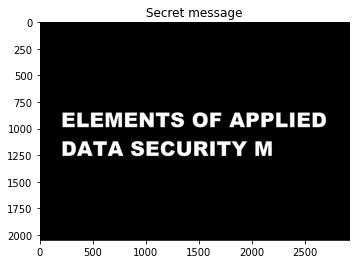

In [3]:
secret_message = load_secret_message(byte_string, "Secret message")

Using AES, for each operation mode (ECB, CBC, CTR and CFB) encrypt and decrypt the image.
For each mode of opration visualize the ciphertext as an image.

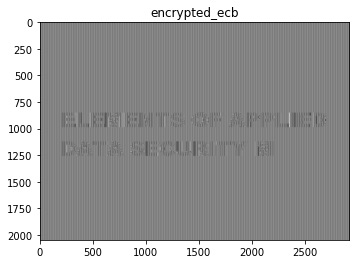

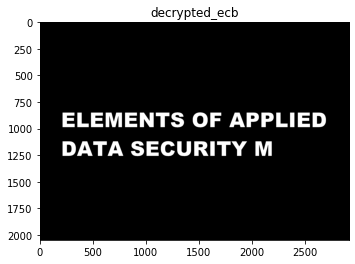

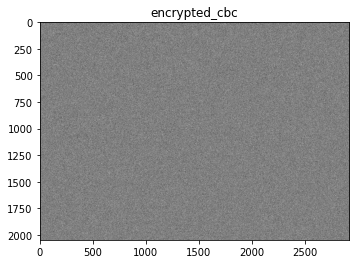

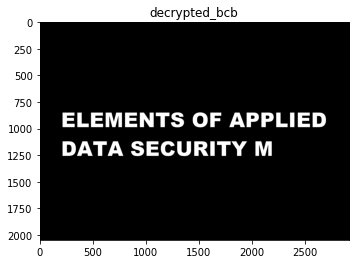

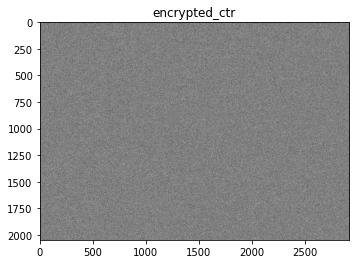

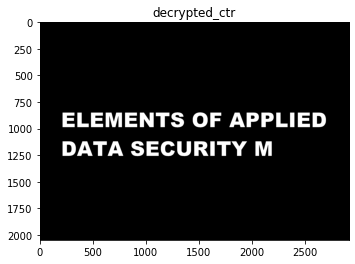

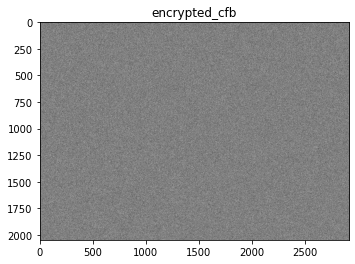

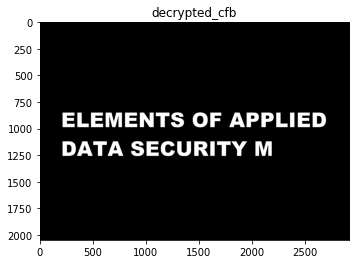

In [4]:
with open('secret_message.bin', 'rb') as f:
        byte_string = f.read()

data = byte_string

key = get_random_bytes(16)

#ECB (Electronic Code Book)

cipher_ecb = AES.new(key, AES.MODE_ECB)
cipher_text_ecb = cipher_ecb.encrypt(data)

encrypted_ecb = load_secret_message(cipher_text_ecb, "encrypted_ecb" )

decrypt_cipher_ecb = AES.new(key, AES.MODE_ECB)
plain_text_ecb = decrypt_cipher_ecb.decrypt(cipher_text_ecb)

decrypted_ecb = load_secret_message(plain_text_ecb, "decrypted_ecb" )


#CBC (Cipher Block Chaining) 

cipher_cbc = AES.new(key, AES.MODE_CBC)

cipher_text_cbc = cipher_cbc.encrypt(pad(data, 16))
iv_cbc = cipher_cbc.iv
#encrypted_cbc = load_secret_message(cipher_text_cbc, "encrypted_cbc" ) - this did not work while padded, new approach:

# Calculate the image dimensions
image_height = 2048
image_width = 2912

# Calculate the expected size of the image
expected_size = image_height * image_width

# Truncate or pad the ciphertext to match the expected size
truncated_ciphertext = cipher_text_cbc[:expected_size]
padded_ciphertext = np.pad(truncated_ciphertext, (0, expected_size - len(truncated_ciphertext)), 'constant')

image = np.frombuffer(padded_ciphertext, dtype=np.uint8).reshape((image_height, image_width))

plt.imshow(image, cmap='gray')
plt.title("encrypted_cbc")
plt.show()

decrypt_cipher_cbc = AES.new(key, AES.MODE_CBC, iv_cbc)
plain_text_cbc = unpad(decrypt_cipher_cbc.decrypt(cipher_text_cbc), 16)
decrypted_cbc = load_secret_message(plain_text_cbc, "decrypted_bcb" )

#CTR (Counter)

cipher_ctr = AES.new(key, AES.MODE_CTR)
cipher_text_ctr = cipher_ctr.encrypt(data)
nonce_ctr = cipher_ctr.nonce
encrypted_ctr = load_secret_message(cipher_text_ctr, "encrypted_ctr" )

decrypt_cipher_ctr = AES.new(key, AES.MODE_CTR, nonce=nonce_ctr)
plain_text_ctr = decrypt_cipher_ctr.decrypt(cipher_text_ctr)
decrypted_ctr = load_secret_message(plain_text_ctr, "decrypted_ctr" )

#CFB (Cipher Feedback)

cipher_cfb = AES.new(key, AES.MODE_CFB)
cipher_text_cfb = cipher_cfb.encrypt(data)
iv_cfb = cipher_cfb.iv
encrypted_cfb = load_secret_message(cipher_text_cfb, "encrypted_cfb" )

decrypt_cipher_cfb = AES.new(key, AES.MODE_CFB, iv=iv_cfb)
plain_text_cfb = decrypt_cipher_cfb.decrypt(cipher_text_cfb)
decrypted_cfb = load_secret_message(plain_text_cfb, "decrypted_cfb" )



As you can see in the results, ECB is by far the weakest one, and could not even hide the original message. 
The rest is represented by white noise, and all of them managed to be correctly decrypted again. 

## RSA

The RSA algorithm is a widely used encryption and decryption method in computer science. It relies on the mathematical properties of large prime numbers to ensure the security of data transmission. The algorithm generates a public key for encryption and a private key for decryption. The strength of RSA lies in the difficulty of factoring large numbers into their prime components. This asymmetry allows for secure communication, where the message can only be decrypted by the recipient possessing the private key.

### Square and Multiply

The Square and Multiply algorithm is a technique used for fast modular exponentiation in cryptography. It reduces the number of modular multiplications required to compute large exponential expressions. The algorithm works by repeatedly squaring the base and multiplying by it if the corresponding exponent bit is 1. This approach significantly reduces the number of multiplications compared to a straightforward exponentiation algorithm. 

In [34]:
def square_and_multiply(base, exp, mod):
    '''Returns base^exponent mod modulus. '''
    
    number = 1
    base = base % mod
    while exp > 0:
        if exp % 2 == 1:
            number = (number * base) % mod
        base = (base * base) % mod
        exp = exp // 2
    return number

#### Testing the Square and Mulitply algoritm implementation

In [27]:
def test_square_and_multiply():
    test_cases = [
        # Test case 1
        {
            "base": 2,
            "exponent": 10,
            "modulus": 13,
            "expected_result": 10
        },
        # Test case 2
        {
            "base": 3,
            "exponent": 7,
            "modulus": 17,
            "expected_result": 11
        },
        # Test case 3
        {
            "base": 5,
            "exponent": 0,
            "modulus": 9,
            "expected_result": 1
        },
        # Test case 4
        {
            "base": 7,
            "exponent": 4,
            "modulus": 12,
            "expected_result": 1
        },
        # Test case 5
        {
            "base": 2,
            "exponent": 12345,
            "modulus": 19,
            "expected_result": 12
        }
    ]

    for i, test_case in enumerate(test_cases):
        result = square_and_multiply(
            test_case["base"], test_case["exponent"], test_case["modulus"]
        )
        expected_result = test_case["expected_result"]
        assert result == expected_result, f"Test case {i+1} failed."

    print("All test cases passed!")

test_square_and_multiply()


All test cases passed!


### Miller Rabin test

The Miller-Rabin algorithm is a probabilistic primality test. It repeatedly selects random witnesses to determine if a given number is composite or probably prime. It uses modular exponentiation and the property that, for a composite number, there are "witnesses" that satisfy certain conditions. If the number passes multiple iterations with different witnesses, it is considered probably prime. However, there is a small probability of error. Increasing the number of iterations improves accuracy but also increases computation time.

In [7]:
def miller_rabin_test(number, num_trials=None):
    ''' Tests if a given number is most likely a prime, returning true or false '''
    if number == 2 or number == 3:
        return True
    if number < 2 or number % 2 == 0:
        return False

    # Write number - 1 as 2^r * d
    r, d = 0, number - 1
    while d % 2 == 0:
        r += 1
        d //= 2

    # Perform Miller-Rabin primality test
    num_trials = num_trials or max(5, int(number.bit_length() ** 0.5))
    for _ in range(num_trials):
        a = random.randint(2, number - 2)
        x = pow(a, d, number)
        if x == 1 or x == number - 1:
            continue
        for _ in range(r - 1):
            x = pow(x, 2, number)
            if x == number - 1:
                break
        else:
            return False

    return True

#### Testing the Miller Rabin algoritm implementation

In [8]:
def test_miller_rabin():
    test_cases = [
        (2, True),
        (3, True),
        (4, False),
        (5, True),
        (6, False),
        (7, True),
        (8, False),
        (9, False),
        (10, False),
        (11, True),
        (12, False),
        (13, True),
        (14, False),
        (15, False),
        (16, False),
        (17, True),
        (18, False),
        (19, True),
        (20, False),
        (21, False),
    ]

    for number, expected_result in test_cases:
        result = miller_rabin_test(number)
        assert result == expected_result, f"Test case {number} failed."

    print("All test cases passed successfully!")

test_miller_rabin()

All test cases passed successfully!


### Extended Eucledian Algorithm

The Extended Euclidean Algorithm (EEA) is an extension of the Euclidean Algorithm used to find the greatest common divisor (GCD) of two integers. In addition to determining the GCD, the EEA also finds the coefficients that satisfy Bézout's identity, which states that the GCD of two numbers can be expressed as a linear combination of the numbers. The EEA is particularly useful for solving modular equations and finding modular inverses. By iteratively applying the algorithm, the EEA calculates the GCD and the coefficients efficiently, providing a powerful tool for number theory and cryptography.

In [9]:
def extended_eucledian_algorithm(a, m):
    '''Computes the inverse of a number a with respect to multiplication modulo m'''
    r0, r1 = m, a
    s0, s1, t0, t1 = 0, 1, 1, 0
    i = 1
    
    while r1 != 0:
        i += 1
        r = r0 % r1
        q = (r0 - r) // r1
        s = s0 - q * s1
        t = t0 - q * t1
        
        r0, r1 = r1, r
        s0, s1 = s1, s
        t0, t1 = t1, t
    
    if r0 != 1:
        raise ValueError("Inverse does not exist")
    
    return s0 % m


#### Testing the EEA

In [10]:
def test_extended_euclidean_algorithm():
    # Test case 1: Inverse exists
    a = 7
    m = 11
    expected_inverse = 8

    inverse = extended_eucledian_algorithm(a, m)
    assert inverse == expected_inverse, f"Test case 1 failed: expected {expected_inverse}, got {inverse}"

    # Test case 2: Inverse does not exist
    a = 4
    m = 8

    try:
        inverse = extended_eucledian_algorithm(a, m)
    except ValueError:
        pass  # Inverse does not exist, the test passed
    else:
        assert False, "Test case 2 failed: expected a ValueError, but no exception was raised"

    print("All test cases passed!")

test_extended_euclidean_algorithm()

All test cases passed!


### Implementation

Implement the RSA class. The role of sender (`Alice`) or receiver (`Bob`) depends on the arguments passed when an instance is created. In detail:
- if `k_pub` is passed RSA instance works as sender (`Alice`)
- Otherwise, RSA instance works as receiver (`Bob`). Therefore, it must generate `k_priv` and `k_pub`.

In [11]:
class RSA():
    
    def __init__(self, key_length=128, k_pub=None, mrt_trials=None):
        """Initialize the RSA instance"""
        self.key_length = key_length
        self.mrt_trials = mrt_trials

        if k_pub is not None:
            self.k_pub = k_pub
        else:
            self._generate_keys()
    
    def _sample_prime_number(self, length, mrt_trials=None):
        ''' Using miller rabin to generate a long prime number '''
        while True:
            number = random.getrandbits(length)
            if miller_rabin_test(number, mrt_trials):
                return number
        
    
    def _generate_keys(self):
        """Generate public and private keys."""
        p = self._sample_prime_number(self.key_length, self.mrt_trials)
        q = self._sample_prime_number(self.key_length, self.mrt_trials)
        n = p * q
        phi_n = (p - 1) * (q - 1)

        e=2
        while (e<phi_n):
            e = random.randint(2, phi_n)
            if (math.gcd(phi_n, e) == 1):
                break
            else:
                e += 1

        d = extended_eucledian_algorithm(e, phi_n)
        self.k_pub = (e, n)
        self.k_priv = (d, n)

        print(f'Public key: {e, n}')
        print(f'Private key: {d, n}')   
    
    def decrypt(self, y):
        """Decrypt the given ciphertext."""
        d, n = self.k_priv
        x = square_and_multiply(y, d, n)
        return x
    
    def encrypt(self, x):
        """Encrypt the given plaintext."""
        e, n = self.k_pub
        y = square_and_multiply(x, e, n)
        return y

#### Testing the RSA implementation

In [28]:
def test_rsa():
    # Test encryption and decryption
    rsa = RSA()
    plaintext = 12345
    print(f'Original message: {plaintext}')
    ciphertext = rsa.encrypt(plaintext)
    print(f'Encrypted message: {ciphertext}')
    decrypted = rsa.decrypt(ciphertext)
    print(f'Decrypted message: {decrypted}')

    assert plaintext == decrypted, "Encryption and decryption failed."

    print("Test passed successfully.")


test_rsa()

Public key: (524338113353237740106406757113428166782190807669518950224203141970523771477, 795591388138646613067864901724755439763329214649680442519992656533543344241)
Private key: (259105810662775469957889311919205795982282681077168984798191974730033956413, 795591388138646613067864901724755439763329214649680442519992656533543344241)
Original message: 12345
Encrypted message: 339575035385457768820321413580739777093833880938077945332406161803169683665
Decrypted message: 12345
Test passed successfully.


##  RSA+AES

#### RSA and EAS in a cryptographic system

RSA and AES can coexist in a cryptographic system by utilizing their respective strengths for different purposes within the system.
RSA is a public-key encryption algorithm used for secure key exchange and digital signatures. It is generally slower than symmetric encryption algorithms like AES. In a cryptographic system, RSA can be used for key exchange and authentication. For example, RSA can be employed to securely exchange AES session keys between two parties. The RSA algorithm generates a pair of keys: a public key for encryption and a private key for decryption. The public key can be shared openly, allowing anyone to encrypt messages or verify digital signatures, while the private key remains secret. AES, on the other hand, is a symmetric encryption algorithm known for its speed and efficiency in encrypting large amounts of data. It uses a single key for both encryption and decryption. AES can be used for bulk data encryption within the cryptographic system. For instance, once the session keys are securely exchanged using RSA, AES can be employed to encrypt and decrypt the actual data being transmitted between the parties.

<img src="system.png" width="600">

With the reference to the previous picture, given an AES key `k_AES = b'0123456701234567'` and a ciphertext stored in `ciphertext_AES.bin`,
simulate a system based on RSA and AES, that allows Bob to decrypt the ciphertext.

In [57]:
class AESCipher:
    def __init__(self, key):
        self.key = key

    def encrypt(self, plaintext):
        cipher = AES.new(self.key, AES.MODE_ECB)
        ciphertext = cipher.encrypt(pad(plaintext, AES.block_size))
        return ciphertext

    def decrypt(self, ciphertext):
        cipher = AES.new(self.key, AES.MODE_ECB)
        plaintext = unpad(cipher.decrypt(ciphertext), AES.block_size)
        return plaintext

In [88]:
k_AES = b'0123456701234567'

with open('ciphertext_AES.bin', 'rb') as f:
        secret_text= f.read()

#create AES for Alice, using the shared key
alice_aes = AESCipher(k_AES)

#Alice encrypt the message (x -> y)
encrypted_message = alice_aes.encrypt(secret_text)

#create Bob's RSA, generating two keys
bob_rsa = RSA()

#create Alice's RSA, using Bob's public key. Alice don't need a private key for this interaction
alice_rsa = RSA(k_pub=bob_rsa.k_pub)

#using RSA, Alice encrypts the shared key using Bob's public key
encrypted_key = alice_rsa.encrypt(int.from_bytes(k_AES, byteorder='big'))

#Bob uses RSA and his to decrypt the key Alice sent using his private key
decrypted_key = bob_rsa.decrypt(encrypted_key)

#testing if it is correct
assert k_AES == decrypted_key.to_bytes(16, byteorder="big"), "Bob got the wrong key from Alice"

print("Keys shared successfully")

#Bob creates a AES with the shared key he got from Alice
bob_aes = AESCipher(decrypted_key.to_bytes(16, byteorder="big"))

#Bob can now decrypt the message with AES
decrypted_message = bob_aes.decrypt(encrypted_message)

#Testing if it is the same
assert secret_text == decrypted_message, "The message is decrypted wrong"

print("Alice and Bob have sucessfully shared the secret text")


Public key: (105512287348532082945102079068035847260572106781238588128913794652537974071, 24572010021084524914217985992792770359175389532266262650553803213824998209407)
Private key: (2738194668139669375940941807623754612182248460174922855841687054202022278839, 24572010021084524914217985992792770359175389532266262650553803213824998209407)
Keys shared successfully
Alice and Bob have sucessfully shared the secret text
